In [2]:
import pandas as pd
import yfinance as yf
import numpy as np

SPX_Constituents processing:

In [3]:
spx_constituents = pd.read_csv("Data/SPX_const_data.csv",index_col=0)
spx_constituents.index.name = "Date"
spx_constituents.index = pd.to_datetime(spx_constituents.index)
spx_constituents_prices= spx_constituents[[col for col in spx_constituents.columns if "price" in col]]
spx_constituents_returns = spx_constituents_prices.pct_change()
spx_constituents_returns = spx_constituents_returns[1:]

SPX_Index Processing:

In [4]:
spx = yf.Ticker("^GSPC")
spx_prices = spx.history(start="2014-12-31", end="2025-01-29")["Close"]
spx_returns = spx_prices.pct_change()
spx_returns = spx_returns[1:]

Beta Calculation:

In [5]:
spx_constituents_returns.index

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2025-01-16', '2025-01-17', '2025-01-20', '2025-01-21',
               '2025-01-22', '2025-01-23', '2025-01-24', '2025-01-27',
               '2025-01-28', '2025-01-29'],
              dtype='datetime64[ns]', name='Date', length=2629, freq=None)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

Skipping DPZ_price due to no overlapping data with index
Skipping MRP-W_price due to no overlapping data with index
Top 10 highest beta stocks:
          Beta
CHD   0.393575
CAG   0.361358
EVRG  0.360765
HRL   0.332527
SJM   0.304834
K     0.302264
GIS   0.297420
CLX   0.288502
KR    0.277803
CPB   0.008546

Top 10 lowest beta stocks:
          Beta
PLTR  2.405481
CZR   2.092304
GEV   2.004919
NCLH  1.895776
CCL   1.868444
ON    1.781859
MPWR  1.753480
RCL   1.691207
LRCX  1.677675
AMAT  1.641983

Beta statistics:
             Beta
count  494.000000
mean     0.990508
std      0.304813
min      0.008546
25%      0.794322
50%      0.988663
75%      1.173880
max      2.405481


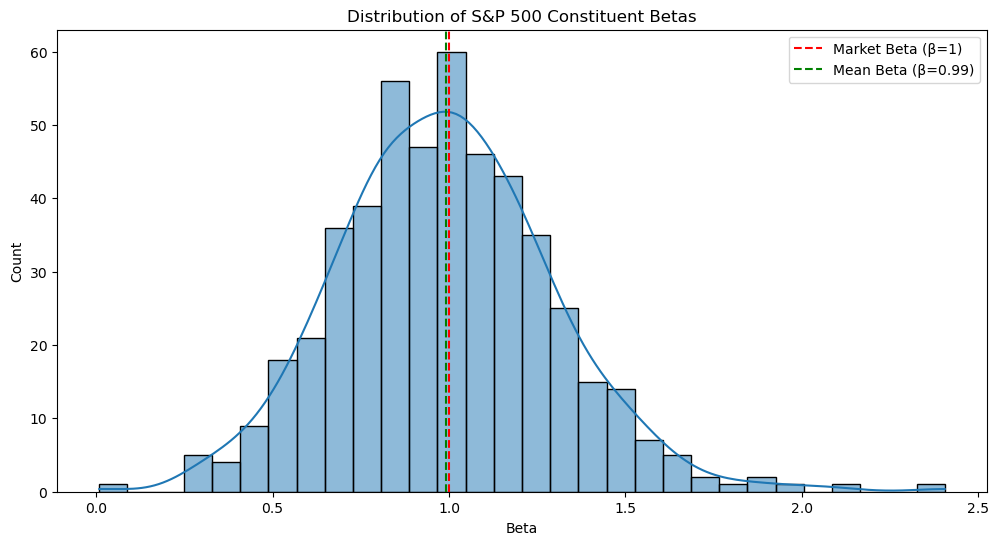

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Handle timezone differences
if hasattr(spx_returns.index, 'tzinfo') and spx_returns.index.tzinfo is not None:
    spx_returns = spx_returns.tz_localize(None)
if hasattr(spx_constituents_returns.index, 'tzinfo') and spx_constituents_returns.index.tzinfo is not None:
    spx_constituents_returns = spx_constituents_returns.tz_localize(None)

# Align data by datetime index
aligned_data = pd.concat([spx_returns, spx_constituents_returns], axis=1)
aligned_data.columns = ['SPX'] + list(spx_constituents_returns.columns)
#Lets do first the beta for 5 years with no clustering:

aligned_data = aligned_data["2019":"2024"]

# Calculate beta for each stock
betas = {}
for column in spx_constituents_returns.columns:
    # Extract data and handle missing values properly
    stock_data = aligned_data[['SPX', column]].copy()
    stock_data.dropna(inplace=True)
    
    if len(stock_data) < 30:  # Ensure minimum sample size for reliable beta
        print(f"Warning: {column} has fewer than 30 data points after dropping NAs")
        if len(stock_data) == 0:
            print(f"Skipping {column} due to no overlapping data with index")
            continue
    
    # Calculate beta
    stock_returns = stock_data[column]
    market_returns = stock_data['SPX']
    
    # Calculate covariance between stock and market
    covariance = np.cov(stock_returns, market_returns)[0, 1]
    
    # Calculate variance of market
    market_variance = np.var(market_returns)
    
    # Calculate beta
    beta = covariance / market_variance
    
    # Extract ticker symbol from column name
    ticker = column.split('_')[0]
    betas[ticker] = beta

# Convert to DataFrame for analysis
beta_df = pd.DataFrame.from_dict(betas, orient='index', columns=['Beta'])
beta_df = beta_df.sort_values('Beta',ascending = False)

# Display the top 10 highest and lowest beta stocks
print("Top 10 highest beta stocks:")
print(beta_df.tail(10))
print("\nTop 10 lowest beta stocks:")
print(beta_df.head(10))

# Calculate basic statistics
print("\nBeta statistics:")
print(beta_df.describe())

# Alternative method using linear regression
regression_betas = {}
for column in spx_constituents_returns.columns:
    # Extract data and handle missing values
    stock_data = aligned_data[['SPX', column]].copy()
    stock_data.dropna(inplace=True)
    
    if len(stock_data) < 30:
        if len(stock_data) == 0:
            continue
    
    # Prepare data for regression
    X = stock_data['SPX'].values.reshape(-1, 1)
    y = stock_data[column].values
    
    # Fit linear regression model
    from sklearn.linear_model import LinearRegression
    model = LinearRegression().fit(X, y)
    
    # Extract beta (slope coefficient)
    ticker = column.split('_')[0]
    regression_betas[ticker] = model.coef_[0]

# Convert regression betas to DataFrame
regression_beta_df = pd.DataFrame.from_dict(regression_betas, orient='index', columns=['Beta'])
regression_beta_df = regression_beta_df.sort_values('Beta',ascending = False)

# Plot histogram of betas
plt.figure(figsize=(12, 6))
sns.histplot(beta_df['Beta'], bins=30, kde=True)
plt.title('Distribution of S&P 500 Constituent Betas')
plt.xlabel('Beta')
plt.axvline(x=1, color='red', linestyle='--', label='Market Beta (β=1)')
plt.axvline(x=beta_df['Beta'].mean(), color='green', linestyle='--', label=f'Mean Beta (β={beta_df["Beta"].mean():.2f})')
plt.legend()

# Compare two methods (optional)
beta_comparison = pd.DataFrame({
    'Cov/Var Beta': beta_df['Beta'],
    'Regression Beta': regression_beta_df['Beta']
})



Do the same with the small caps:


In [9]:
russ_2000_tickers = pd.read_excel("Data\RTY as of Feb 27 20251.xlsx")["Ticker"].tolist()

In [10]:
russ_2000_tickers = [tick.split(" ")[0] for tick in russ_2000_tickers]


In [11]:
russ_2000_data = yf.download(russ_2000_tickers, start="2014-12-31", end="2025-01-29")["Close"]

[                       0%                       ]  2 of 1951 completed

YF.download() has changed argument auto_adjust default to True


[*******               15%                       ]  288 of 1951 completedFailed to get ticker 'GEF/B' reason: Expecting value: line 1 column 1 (char 0)
[**********************92%*******************    ]  1792 of 1951 completedFailed to get ticker 'BKD' reason: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)
[*********************100%***********************]  1950 of 1951 completed

1201 Failed downloads:
['GEF/B', 'BKD']: YFTzMissingError('possibly delisted; no timezone found')
['IPAR', 'HFFG', 'RDFN', 'FOR', 'BUR', 'APLT', 'CTKB', 'UMH', 'WULF', 'CATY', 'BELFA', 'KRO', 'LRMR', 'INMB', 'CNDT', 'HCI', 'TVTX', 'SPNS', 'QCRH', 'NTGR', 'RUSHA', 'PRSU', 'NODK', 'SVV', 'URGN', 'SFM', 'HOFT', 'BYON', 'UTI', 'CENT', 'LWLG', 'PTON', 'MD', 'MLKN', 'ALT', 'KNSA', 'PLAY', 'ACHV', 'IAS', 'WNS', 'VHI', 'KWR', 'RVMD', 'SCPH', 'SWKH', 'GRWG', 'RHP', 'BTU', 'GNL', 'MATV', 'DBRG', 'CNO', 'TREE', 'MHLD', 'VTOL', 'METC', 'LILA', 'KN', 'PFS', 'TRVI', 'ATRO'

In [12]:
russ_2000_returns = russ_2000_data.pct_change()
russ_2000_returns = russ_2000_returns[1:]

Skipping AAOI due to no overlapping data with index
Skipping AAT due to no overlapping data with index
Skipping ABCB due to no overlapping data with index
Skipping ABM due to no overlapping data with index
Skipping ABOS due to no overlapping data with index
Skipping ABR due to no overlapping data with index
Skipping ABSI due to no overlapping data with index
Skipping ACA due to no overlapping data with index
Skipping ACAD due to no overlapping data with index
Skipping ACCD due to no overlapping data with index
Skipping ACCO due to no overlapping data with index
Skipping ACDC due to no overlapping data with index
Skipping ACHR due to no overlapping data with index
Skipping ACHV due to no overlapping data with index
Skipping ACLS due to no overlapping data with index
Skipping ACLX due to no overlapping data with index
Skipping ACRE due to no overlapping data with index
Skipping ACRV due to no overlapping data with index
Skipping ACTG due to no overlapping data with index
Skipping ACVA du

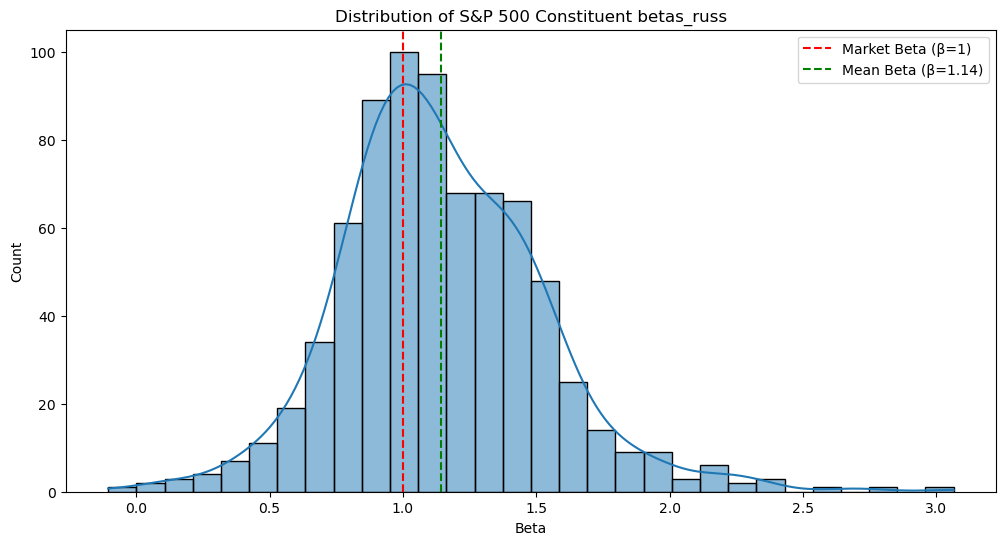

In [13]:
# Handle timezone differences
if hasattr(spx_returns.index, 'tzinfo') and spx_returns.index.tzinfo is not None:
    spx_returns = spx_returns.tz_localize(None)
if hasattr(russ_2000_returns.index, 'tzinfo') and russ_2000_returns.index.tzinfo is not None:
    russ_2000_returns = russ_2000_returns.tz_localize(None)

# Align data by datetime index
aligned_data = pd.concat([spx_returns, russ_2000_returns], axis=1)
aligned_data.columns = ['SPX'] + list(russ_2000_returns.columns)
#Lets do first the beta for 5 years with no clustering:

aligned_data = aligned_data["2019":"2024"]

# Calculate beta for each stock
betas_russ = {}
for column in russ_2000_returns.columns:
    # Extract data and handle missing values properly
    stock_data = aligned_data[['SPX', column]].copy()
    stock_data.dropna(inplace=True)
    
    if len(stock_data) < 30:  # Ensure minimum sample size for reliable beta
        print(f"Warning: {column} has fewer than 30 data points after dropping NAs")
        if len(stock_data) == 0:
            print(f"Skipping {column} due to no overlapping data with index")
            continue
    
    # Calculate beta
    stock_returns = stock_data[column]
    market_returns = stock_data['SPX']
    
    # Calculate covariance between stock and market
    covariance = np.cov(stock_returns, market_returns)[0, 1]
    
    # Calculate variance of market
    market_variance = np.var(market_returns)
    
    # Calculate beta
    beta = covariance / market_variance
    
    # Extract ticker symbol from column name
    ticker = column.split('_')[0]
    betas_russ[ticker] = beta

# Convert to DataFrame for analysis
beta_df_russ = pd.DataFrame.from_dict(betas_russ, orient='index', columns=['Beta'])
beta_df_russ = beta_df_russ.sort_values('Beta',ascending = False)

# Display the top 10 highest and lowest beta stocks
print("Top 10 highest beta stocks:")
print(beta_df_russ.tail(10))
print("\nTop 10 lowest beta stocks:")
print(beta_df_russ.head(10))

# Calculate basic statistics
print("\nBeta statistics:")
print(beta_df_russ.describe())

# Alternative method using linear regression
regression_betas_russ = {}
for column in russ_2000_returns.columns:
    # Extract data and handle missing values
    stock_data = aligned_data[['SPX', column]].copy()
    stock_data.dropna(inplace=True)
    
    if len(stock_data) < 30:
        if len(stock_data) == 0:
            continue
    
    # Prepare data for regression
    X = stock_data['SPX'].values.reshape(-1, 1)
    y = stock_data[column].values
    
    # Fit linear regression model
    from sklearn.linear_model import LinearRegression
    model = LinearRegression().fit(X, y)
    
    # Extract beta (slope coefficient)
    ticker = column.split('_')[0]
    regression_betas_russ[ticker] = model.coef_[0]

# Convert regression betas_russ to DataFrame
regression_beta_df_russ = pd.DataFrame.from_dict(regression_betas_russ, orient='index', columns=['Beta'])
regression_beta_df_russ = regression_beta_df_russ.sort_values('Beta')

# Plot histogram of betas_russ
plt.figure(figsize=(12, 6))
sns.histplot(beta_df_russ['Beta'], bins=30, kde=True)
plt.title('Distribution of S&P 500 Constituent betas_russ')
plt.xlabel('Beta')
plt.axvline(x=1, color='red', linestyle='--', label='Market Beta (β=1)')
plt.axvline(x=beta_df_russ['Beta'].mean(), color='green', linestyle='--', label=f'Mean Beta (β={beta_df_russ["Beta"].mean():.2f})')
plt.legend()

# Compare two methods (optional)
beta_comparison_russ = pd.DataFrame({
    'Cov/Var Beta': beta_df_russ['Beta'],
    'Regression Beta': regression_beta_df_russ['Beta']
})


In [41]:
top_200_betas_russ = beta_df_russ.head(100)
top_50_betas_SP=beta_df.head(25)

In [21]:
top_200_betas_russ_returns

Ticker,ACMR,ADNT,AIRS,ALDX,ALEC,ALGT,ALKT,ALTM,AMBA,AMRC,...,VRTS,VSTM,VTYX,WEAV,WOOF,WS,XMTR,XPOF,ZETA,ZIP
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-02,-0.044524,0.003575,-0.040053,0.008547,0.001253,-0.018400,-0.041237,0.003893,-0.018763,-0.008841,...,-0.025356,0.019656,0.008097,0.006103,0.000000,-0.043061,-0.034809,-0.018619,-0.047619,-0.023741
2024-01-03,-0.054097,-0.070156,-0.034771,-0.053672,-0.037547,-0.058577,-0.019785,-0.085319,-0.057034,-0.060210,...,-0.027670,-0.014458,0.016064,-0.022530,-0.075949,0.025288,-0.042412,-0.105929,-0.053571,-0.004421
2024-01-04,-0.037373,0.003242,0.028818,-0.002985,0.037711,0.025413,0.000878,-0.007580,-0.038970,-0.010847,...,0.038890,0.034230,-0.007905,-0.005319,-0.010274,-0.004715,-0.004519,-0.014147,0.011321,0.011103
2024-01-05,-0.002353,0.007344,0.030812,-0.032934,-0.061404,0.009070,0.011399,0.044053,0.010459,-0.016792,...,-0.016049,0.002364,-0.071713,-0.017825,0.027682,-0.091472,-0.016041,0.025112,0.011194,0.010981
2024-01-08,0.004127,0.010207,0.086957,0.037152,0.073431,0.027219,0.074556,-0.040788,0.042491,0.011154,...,0.018147,0.093160,0.115880,0.039020,-0.020202,0.051745,0.037835,-0.013998,0.060271,0.028964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-22,0.005379,-0.038924,-0.041588,0.028630,0.028902,-0.009307,-0.012864,0.001748,-0.013188,-0.047521,...,-0.007642,0.024119,0.038462,0.003167,-0.025840,-0.015766,-0.030828,0.030760,-0.007361,-0.018336
2025-01-23,-0.014446,0.005956,0.037475,0.000000,0.016854,-0.022239,0.007932,0.000000,0.011648,-0.016486,...,0.006409,0.012681,0.069444,0.009470,0.023873,-0.019614,0.007271,-0.029233,-0.006886,0.007184
2025-01-24,0.009772,0.014802,-0.028517,0.017893,-0.011050,0.007157,-0.010961,0.003490,-0.031390,-0.000882,...,-0.007509,0.059034,-0.025974,0.013133,-0.002591,-0.006669,-0.017744,-0.008156,-0.009600,-0.002853


In [42]:
top_50_betas_returns = spx_constituents_returns[[col for col in spx_constituents_returns.columns if col.split("_")[0] in top_50_betas_SP.index]]
top_200_betas_russ_returns = russ_2000_returns[[col for col in russ_2000_returns.columns if col in top_200_betas_russ.index]]
top_50_betas_returns = top_50_betas_returns["2024":"2025"]
top_200_betas_russ_returns = top_200_betas_russ_returns["2024":"2025"]
sp_weights = top_50_betas_SP / top_50_betas_SP.sum()
russ_weights = top_200_betas_russ / top_200_betas_russ.sum()
# Create empty DataFrames to store the portfolio returns
sp_beta_weighted_portfolio = pd.DataFrame(index=top_50_betas_returns.index)
russ_beta_weighted_portfolio = pd.DataFrame(index=top_200_betas_russ_returns.index)

# Calculate the beta-weighted portfolio returns for S&P 500
weighted_returns_sp = pd.DataFrame(index=top_50_betas_returns.index)
for ticker in top_50_betas_SP.index:
    ticker_cols = [col for col in top_50_betas_returns.columns if col.split("_")[0] == ticker]
    if ticker_cols:
        # For each ticker, weight its returns by its beta weight
        ticker_weight = sp_weights.loc[ticker]
        print(ticker_weight)
        for col in ticker_cols:
            weighted_returns_sp[col] = top_50_betas_returns[col] * ticker_weight["Beta"]
            print(weighted_returns_sp[col])

# Sum across all weighted returns to get the portfolio return
sp_beta_weighted_portfolio['returns'] = weighted_returns_sp.sum(axis=1)

# Calculate the beta-weighted portfolio returns for Russell 2000
weighted_returns_russ = pd.DataFrame(index=top_200_betas_russ_returns.index)
for ticker in top_200_betas_russ.index:
    # Check if the ticker exists in the returns dataframe
    if ticker in top_200_betas_russ_returns.columns:
        # Weight the returns by the beta weight
        ticker_weight = russ_weights.loc[ticker]
        weighted_returns_russ[ticker] = top_200_betas_russ_returns[ticker] * ticker_weight["Beta"]

# Sum across all weighted returns to get the portfolio return
russ_beta_weighted_portfolio['returns'] = weighted_returns_russ.sum(axis=1)


Beta    0.057092
Name: PLTR, dtype: float64
Date
2024-01-01         NaN
2024-01-02         NaN
2024-01-03         NaN
2024-01-04         NaN
2024-01-05         NaN
                ...   
2025-01-23    0.001567
2025-01-24    0.000000
2025-01-27   -0.002559
2025-01-28    0.003625
2025-01-29   -0.001003
Name: PLTR_price, Length: 283, dtype: float64
Beta    0.049659
Name: CZR, dtype: float64
Date
2024-01-01    0.000000
2024-01-02    0.000953
2024-01-03   -0.002889
2024-01-04   -0.000099
2024-01-05    0.000000
                ...   
2025-01-23    0.000574
2025-01-24    0.000640
2025-01-27    0.000617
2025-01-28    0.001021
2025-01-29   -0.000042
Name: CZR_price, Length: 283, dtype: float64
Beta    0.047585
Name: GEV, dtype: float64
Date
2024-01-01         NaN
2024-01-02         NaN
2024-01-03         NaN
2024-01-04         NaN
2024-01-05         NaN
                ...   
2025-01-23    0.001182
2025-01-24   -0.001872
2025-01-27   -0.010240
2025-01-28    0.003622
2025-01-29   -0.000181
Name:

In [43]:
sp_beta_weighted_portfolio

,returns
Date,
2024-01-01,0.000000
2024-01-02,-0.025083
2024-01-03,-0.027180
2024-01-04,-0.003040
2024-01-05,0.006013
...,...
2025-01-23,0.007501
2025-01-24,-0.015494
2025-01-27,-0.025702


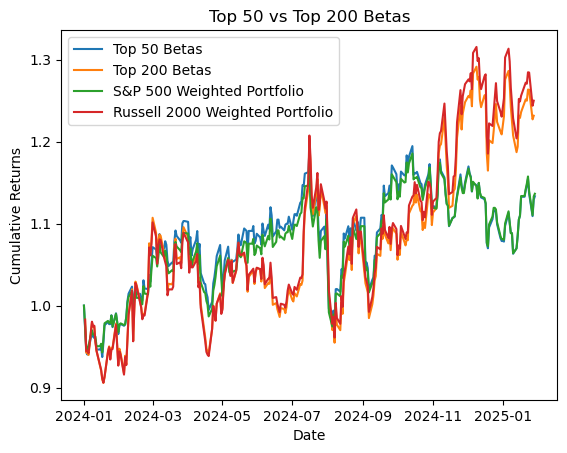

In [44]:
mean_returns_top_200 = top_200_betas_russ_returns.mean(axis = 1)
cum_returns_top_200 = (1 + mean_returns_top_200).cumprod()
mean_returns_top_50 = top_50_betas_returns.mean(axis = 1)
cum_returns_top_50 = (1 + mean_returns_top_50).cumprod()
cum_returns_sp_weighted = (1 + sp_beta_weighted_portfolio['returns']).cumprod()
cum_returns_russ_weighted = (1 + russ_beta_weighted_portfolio['returns']).cumprod()
plt.plot(cum_returns_top_50, label="Top 50 Betas")
plt.plot(cum_returns_top_200, label="Top 200 Betas")
plt.plot(cum_returns_sp_weighted, label="S&P 500 Weighted Portfolio")
plt.plot(cum_returns_russ_weighted, label="Russell 2000 Weighted Portfolio")
plt.title("Top 50 vs Top 200 Betas")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()


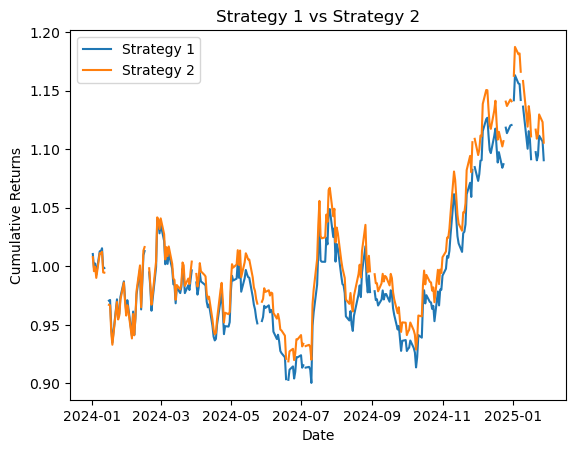

Mean Annualized Returns for Strategy 1: 0.10429322336668077
Mean Annualized Returns for Strategy 2: 0.11739331340560358
Standard Deviation for Strategy 1: 0.2155146502733005
Standard Deviation for Strategy 2: 0.21693847043812098
Sharpe Ratio for Strategy 1: 0.48392637453845233
Sharpe Ratio for Strategy 2: 0.5411364483603132


In [47]:
strategy_1 = mean_returns_top_200-mean_returns_top_50
strategy_2 = russ_beta_weighted_portfolio['returns'] - sp_beta_weighted_portfolio['returns']
strategy_cumulative_returns_1 = (1 + strategy_1).cumprod()
strategy_cumulative_returns_2 = (1 + strategy_2).cumprod()
plt.plot(strategy_cumulative_returns_1, label="Strategy 1")
plt.plot(strategy_cumulative_returns_2, label="Strategy 2")
plt.title("Strategy 1 vs Strategy 2")   
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()
print(f"Mean Annualized Returns for Strategy 1: {strategy_1.mean()*252}")
print(f"Mean Annualized Returns for Strategy 2: {strategy_2.mean()*252}")
print(f"Standard Deviation for Strategy 1: {strategy_1.std()*np.sqrt(252)}")
print(f"Standard Deviation for Strategy 2: {strategy_2.std()*np.sqrt(252)}")
# Calculate the Sharpe Ratio for both strategies
sharpe_ratio_1 = strategy_1.mean() / strategy_1.std()
sharpe_ratio_2 = strategy_2.mean() / strategy_2.std()
print(f"Sharpe Ratio for Strategy 1: {sharpe_ratio_1*np.sqrt(252)}")
print(f"Sharpe Ratio for Strategy 2: {sharpe_ratio_2*np.sqrt(252)}")


In [48]:
import scipy.stats as stats

# For strategy_1
n_1 = len(strategy_1)  # Number of observations
sharpe_ratio_1 = strategy_1.mean() / strategy_1.std()
# The t-statistic when testing if Sharpe = 0
t_stat_1 = sharpe_ratio_1 * np.sqrt(n_1)
# P-value (two-tailed test)
p_value_1 = 2 * (1 - stats.t.cdf(abs(t_stat_1), df=n_1-1))

# For strategy_2
n_2 = len(strategy_2)  # Number of observations
sharpe_ratio_2 = strategy_2.mean() / strategy_2.std()
# The t-statistic when testing if Sharpe = 0
t_stat_2 = sharpe_ratio_2 * np.sqrt(n_2)
# P-value (two-tailed test)
p_value_2 = 2 * (1 - stats.t.cdf(abs(t_stat_2), df=n_2-1))

print(f"Strategy 1 - Sharpe: {sharpe_ratio_1:.4f}, t-stat: {t_stat_1:.4f}, p-value: {p_value_1:.4f}")
print(f"Strategy 2 - Sharpe: {sharpe_ratio_2:.4f}, t-stat: {t_stat_2:.4f}, p-value: {p_value_2:.4f}")

Strategy 1 - Sharpe: 0.0305, t-stat: 0.5128, p-value: 0.6085
Strategy 2 - Sharpe: 0.0341, t-stat: 0.5735, p-value: 0.5668
